# Practical Machine Learning
# Lab 4
## Neural Networks

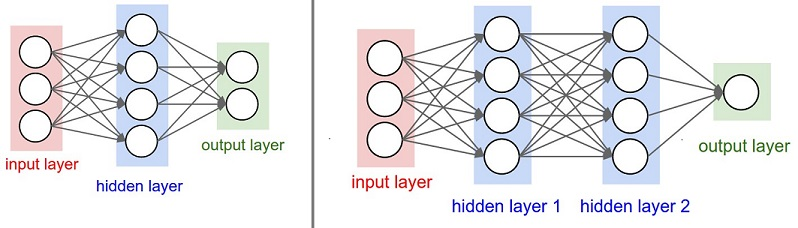


Left: A 2-layer Neural Network (one hidden layer of 4 neurons (or units) and one output layer with 2 neurons), and three inputs. Right: A 3-layer neural network with three inputs, two hidden layers of 4 neurons each and one output layer. Notice that in both cases there are connections between neurons across layers, but not within a layer.

### In order to do this lab you must have tensorflow 2.0  installed on your computer.

### We are going to classify the images from the CIFAR dataset using neural networks.

## CIFAR 

This dataset consists of 60,000 tiny images that are 32 pixels high and wide. Each image is labeled with one of 10 classes (for example “airplane, automobile, bird, etc”). These 60,000 images are partitioned into a training set of 50,000 images and a test set of 10,000 images. 

The classes are:
- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck.

Since neural network takes more time to train then the previous models we've been working with, we will use only the first subset of 10000 images.



In [20]:
from os import path
import os
import numpy as np
import matplotlib.pyplot as plt
import nvitop

ROOT_PATH = '..'
DATA_PATH = path.join(ROOT_PATH, 'data')
WEIGHTS_PATH = path.join(ROOT_PATH, 'weights')
CHECKPOINTS_PATH = path.join(ROOT_PATH, 'checkpoints')

In [21]:
# load training data
train_images_raw = np.load(path.join(DATA_PATH, 'train_images.npy'))
train_labels = np.load(path.join(DATA_PATH, 'train_labels.npy'))
print('The number of images for training is %d.' % train_images_raw.shape[0])

The number of images for training is 10000.


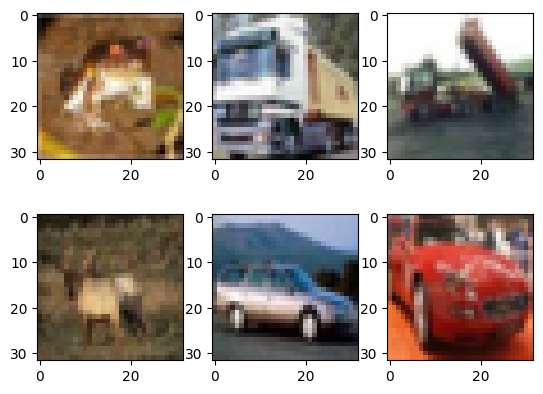

In [22]:
num_cols = 3
num_rows = 2
for i in range(num_rows):
    for j in range(num_cols):
        plt.subplot(num_rows, num_cols, i * num_cols + j + 1) 
        im = train_images_raw[i * num_cols + j].copy()  
        plt.imshow(im)
plt.show()

## Training a fully connected neural network using Keras

## 1. Load the data

In [23]:
# training data is already loaded
# load the test data
test_images_raw = np.load(path.join(DATA_PATH, 'test_images.npy'))
test_labels = np.load(path.join(DATA_PATH, 'test_labels.npy'))

## 2. Prepare the data
Convert the data from uint8 to float32, normalize the pixel data from [0, 255] to [0, 1]

Compute the mean image and substract it from each training and test image.

In [24]:
# write your code her
# TODO: 2.1 convert int to float
train_images = train_images_raw.astype(np.float32) / 255.
test_images = test_images_raw.astype(np.float32) / 255.

# TODO: 2.2 compute mean training image
train_image_mean = train_images.mean(axis=(0, 3))
test_image_mean = test_images.mean(axis=(0, 3))

# TODO: 2.3 subtract the mean image from training and test data.
train_images -= np.expand_dims(train_image_mean, axis=2)
test_images -= np.expand_dims(test_image_mean, axis=2)
# train_images -= train_image_mean
# test_images -= test_image_mean

## 3. Build the neural network

You are going to build a neural network with 5 fully connected layers, activation function _relu_ and a dropout layer inserted before the last layer. Our last (5-th) layer has 10 units (the number of classes) and its activation function is _softmax_.

In [25]:
# Disable GPU
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [26]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)), # we use this layer to flatten/vectorize the images
  tf.keras.layers.Dense(512, activation='relu'), # we add a fully connected layer with 512 units using relu as activation function
  tf.keras.layers.Dense(512, activation='relu'), # we add a fully connected layer with 512 units using relu as activation function
  tf.keras.layers.Dense(1024, activation='relu'), # we add a fully connected layer with 1024 units using relu as activation function
  tf.keras.layers.Dense(1024, activation='relu'), # we add a fully connected layer with 1024 units using relu as activation function
  tf.keras.layers.Dropout(0.2), # we add a dropout layer with the dropout rate 0.2
  tf.keras.layers.Dense(10, activation='softmax') # we add a fully connected layer with 10 units (the number of classes) using softmax as activation function
])

if not path.exists(WEIGHTS_PATH):
  os.mkdir(WEIGHTS_PATH)

model.save_weights(WEIGHTS_PATH + '/initial_weights.h5')

## 4. Compile the model
When you compile a model you should specify:
- the optimizer
    - SGD, Adam, RMSprop
    - Adam - a good optimizer for many cases. Adam adjusts the learning rate throughout training.
    - you can find more optimizers here: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers 
- the loss
    - MSE, MAE, sparse_categorical_crossentropy, categorical_crossentropy, BinaryCrossentropy
    - you can find more losses here: https://www.tensorflow.org/api_docs/python/tf/keras/losses   
- the metrics
    - Acurracy, Precision, Recall, MeanAbsoluteError, MeanSquaredError
    - you can find more metrics here: https://www.tensorflow.org/api_docs/python/tf/keras/metrics  

In [27]:
# import SGD and Adam optimizers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop 

# define the optimizer, set the learning rate and the momentum (for SGD with momentum)
optimizer = SGD(learning_rate=0.001, momentum=0.9)

# compile the model specifying the optimizer, the loss and the metrics (as an array).
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 5. Train and evaluate the model

- Create 'checkpoints' dir, this is the directory where we save the model after each epoch.

In [28]:
import os

if not os.path.exists(CHECKPOINTS_PATH):
    os.makedirs(CHECKPOINTS_PATH)

- In order to save the model (a checkpoint) we have to define a callback.

In [29]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINTS_PATH + '/model.{epoch:05d}.hdf5'
)

- We will use TensorBoard to see the metrics and the loss after each epoch.
We can specify if we want to save the values after each step or epoch using the *update_freq* parameter.
- To start tensorboard type (using Anaconda) *tensorboard --logdir=logs/train* in the current directory. *logs* is the folder we pass to the *log_dir* parameter. 

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = os.path.join(ROOT_PATH, 'logs'),
    write_graph = True,
    update_freq = 'epoch'
)

- Now we'll start the training using the *fit* function.
    - the first param is the training data
    - the 2nd param is the training labels
    - epochs: the number of epoch we want to train the model
    - batch_size: the number of examples in an iteration (an update step)
    - callbacks: the callbacks we want to be done
    - validation_data: we can pass a tuple with validation data and validation labels
    - initial_epoch: if you want to continue the training from a specific epoch, after you restore (load) the model, you should also specify the starting epoch.

In [31]:
model.fit(train_images[:-1000], train_labels[:-1000],
          epochs=10, batch_size=32, initial_epoch=0,
          callbacks=[checkpoint_callback, tensorboard_callback],
          validation_data=(train_images[-1000:], train_labels[-1000:]))

Epoch 1/10
282/282 [==============================] - 1s 3ms/step - loss: 2.2167 - accuracy: 0.2119 - val_loss: 2.1200 - val_accuracy: 0.2550
Epoch 2/10
282/282 [==============================] - 1s 2ms/step - loss: 2.0021 - accuracy: 0.2991 - val_loss: 1.9295 - val_accuracy: 0.3090
Epoch 3/10
282/282 [==============================] - 1s 2ms/step - loss: 1.8466 - accuracy: 0.3487 - val_loss: 1.8126 - val_accuracy: 0.3550
Epoch 4/10
282/282 [==============================] - 1s 2ms/step - loss: 1.7408 - accuracy: 0.3887 - val_loss: 1.7422 - val_accuracy: 0.3760
Epoch 5/10
282/282 [==============================] - 1s 2ms/step - loss: 1.6543 - accuracy: 0.4132 - val_loss: 1.6745 - val_accuracy: 0.4010
Epoch 6/10
282/282 [==============================] - 1s 2ms/step - loss: 1.5803 - accuracy: 0.4434 - val_loss: 1.6380 - val_accuracy: 0.3980
Epoch 7/10
282/282 [==============================] - 1s 3ms/step - loss: 1.5131 - accuracy: 0.4630 - val_loss: 1.5952 - val_accuracy: 0.4160
Epoch 

- You can see the input shape by accesing model.input_shape
- You can see the output shape by accesing model.output_shape
- You can see the weights by accesing model.weights

In [32]:
print('the input shape is ', model.input_shape)
print('the output shape is ', model.output_shape)
print('the length of the weights is', len(model.weights))

the input shape is  (None, 32, 32, 3)
the output shape is  (None, 10)
the length of the weights is 10


- Now, we'll evaluate the model on the test data using the *evaluate* function, it returns the loss value and metrics values for the model in test mode.

In [33]:
test_loss, test_metrics = model.evaluate(test_images, test_labels, verbose=0) 
print('test loss', test_loss)
print('test metrics', test_metrics)

test loss 1.555717945098877
test metrics 0.4580000042915344


- Now, you are going to open Tensorboard to see the epoch that has the best accuracy on the validation set, then we'll restore those weights in order to evaluate the network on the testing set.

In [34]:
from tensorflow.keras.models import load_model

best_epoch = 10
best_model = load_model(path.join(CHECKPOINTS_PATH, 'model.%05d.hdf5' % best_epoch))
predicted_test_labels_scores = best_model.predict(test_images)
predicted_test_labels = np.argmax(predicted_test_labels_scores, axis=-1)
accuracy = np.mean(predicted_test_labels == test_labels)
print('accuracy = ', accuracy)

63/63 [==============================] - 0s 884us/step
accuracy =  0.458


## Exercises

## 1. Train the previous network without subtracting the mean image from data. What do  you notice in terms of accuracy and loss?

In [35]:
# Write your code here
model.load_weights(WEIGHTS_PATH + '/initial_weights.h5')

# Transform images into [0, 1]
scaled_train_images = train_images_raw.astype(np.float32) / 255.
scaled_test_images = test_images_raw.astype(np.float32) / 255.

# Train on unscaled images
model.fit(scaled_train_images[:-1000], train_labels[:-1000],
          epochs=10, batch_size=32, initial_epoch=0,
          callbacks=(checkpoint_callback, tensorboard_callback),
          validation_data=(scaled_train_images[-1000:], train_labels[-1000:]))

Epoch 1/10
282/282 [==============================] - 1s 3ms/step - loss: 2.1349 - accuracy: 0.2157 - val_loss: 1.9745 - val_accuracy: 0.2790
Epoch 2/10
282/282 [==============================] - 1s 3ms/step - loss: 1.9184 - accuracy: 0.3040 - val_loss: 1.8907 - val_accuracy: 0.3400
Epoch 3/10
282/282 [==============================] - 1s 3ms/step - loss: 1.8298 - accuracy: 0.3439 - val_loss: 1.8139 - val_accuracy: 0.3570
Epoch 4/10
282/282 [==============================] - 1s 3ms/step - loss: 1.7603 - accuracy: 0.3669 - val_loss: 1.8220 - val_accuracy: 0.3400
Epoch 5/10
282/282 [==============================] - 1s 3ms/step - loss: 1.7162 - accuracy: 0.3948 - val_loss: 1.7394 - val_accuracy: 0.3880
Epoch 6/10
282/282 [==============================] - 1s 3ms/step - loss: 1.6672 - accuracy: 0.4048 - val_loss: 1.7381 - val_accuracy: 0.3750
Epoch 7/10
282/282 [==============================] - 1s 3ms/step - loss: 1.6339 - accuracy: 0.4167 - val_loss: 1.7072 - val_accuracy: 0.3860
Epoch 

In [36]:
test_loss, test_accuracy = model.evaluate(scaled_test_images, test_labels)
print('test loss', test_loss)
print('test metrics', test_metrics)

63/63 [==============================] - 0s 1ms/step - loss: 1.6218 - accuracy: 0.4290
test loss 1.6218315362930298
test metrics 0.4580000042915344


## 2. Create a network that has the following configuration:
    - L1. dense layer with 256 units and activation function relu
    - L2. dense layer with 256 units and activation function relu
    - L3. dense layer with 256 units and activation function relu 
    - L4. dense layer with 512 units and activation function relu
    - L5. dense layer with 512 units and activation function relu
    - L6. dense layer with 512 units and activation function relu 
    - L7. dense layer with 10 units and activation function softmax

a) Train the network for 10 epochs using Stochastic Gradient Descent with momentum set to 0.9, learning rate set to 0.001 and save the accuracy on the test set.

b) Train the network for 10 epochs using Adam optimizer, learning rate set to 0.001 and save the accuracy on the test set.

As validation data use the last 1000 examples from the training set.

Which configuration is better? 

c) Train the network for 10 epochs using Adam optimizer, learning rate set to 0.1. What do you notice?


In [49]:
def create_neural_network(optim: tf.keras.optimizers.Optimizer, name: str) -> tf.keras.Model:
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
  ], name)

  model.save_weights(WEIGHTS_PATH + f'/initial_{name}.h5')

  model.compile(optimizer=optim, loss='sparse_categorical_crossentropy',
                metrics=['accuracy'], )

  return model

In [53]:
from tensorflow.keras.optimizers import Adam, SGD
from nvitop.callbacks.keras import GpuStatsLogger

# write your code here
gpu_stats_callback = GpuStatsLogger(['/gpu:0'])

# 2.1 define the model and compile
model_a = create_neural_network(SGD(learning_rate=1e-3, momentum=9e-1), 'network_a')
model_b = create_neural_network(Adam(learning_rate=1e-3), 'network_b')
model_c = create_neural_network(Adam(learning_rate=1e-1), 'network_c')

# 2.3 train the model
valid_fr = 1e-1
i_train = i_valid = int((1 - valid_fr) * train_images.shape[0])

for i, model in enumerate([model_a, model_b, model_c]):
  print(f'model_{chr(ord("a") + i)}')

  model.fit(train_images[:i_train], train_labels[:i_train],
              validation_data=(train_images[i_train:], train_labels[i_train:]),
              batch_size=32, epochs=10, initial_epoch=0)

  test_loss, test_accuracy = model.evaluate(test_images, test_labels)
  print('test_accuracy = ', test_accuracy)
  print('test_loss = ', test_loss)

model_a
Epoch 1/10
282/282 [==============================] - 1s 3ms/step - loss: 2.2853 - accuracy: 0.1647 - val_loss: 2.2560 - val_accuracy: 0.1900
Epoch 2/10
282/282 [==============================] - 1s 2ms/step - loss: 2.1833 - accuracy: 0.2251 - val_loss: 2.0985 - val_accuracy: 0.2410
Epoch 3/10
282/282 [==============================] - 1s 2ms/step - loss: 2.0084 - accuracy: 0.2836 - val_loss: 1.9390 - val_accuracy: 0.3000
Epoch 4/10
282/282 [==============================] - 1s 2ms/step - loss: 1.8779 - accuracy: 0.3224 - val_loss: 1.8538 - val_accuracy: 0.3170
Epoch 5/10
282/282 [==============================] - 1s 2ms/step - loss: 1.7778 - accuracy: 0.3599 - val_loss: 1.7936 - val_accuracy: 0.3390
Epoch 6/10
282/282 [==============================] - 1s 3ms/step - loss: 1.6943 - accuracy: 0.3909 - val_loss: 1.7411 - val_accuracy: 0.3740
Epoch 7/10
282/282 [==============================] - 1s 3ms/step - loss: 1.6130 - accuracy: 0.4179 - val_loss: 1.6594 - val_accuracy: 0.398